# Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Write your Algorithm
* [Step 6](#step6): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

Make sure that you've downloaded the required human and dog datasets:
* Download the [dog dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip).  Unzip the folder and place it in this project's home directory, at the location `/dogImages`. 

* Download the [human dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip).  Unzip the folder and place it in the home directory, at location `/lfw`.  

*Note: If you are using a Windows machine, you are encouraged to use [7zip](http://www.7-zip.org/) to extract the folder.*

In the code cell below, we save the file paths for both the human (LFW) dataset and dog dataset in the numpy arrays `human_files` and `dog_files`.

## Step 1: Detect Humans

Run this command and  restart your kernel to avoid any errors ahead.

In [14]:
!pip install Pillow==5.4.1
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
import torchvision
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import dlib
import torch.optim as optim
from glob import glob
import cv2
from PIL import Image
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
if_cuda = torch.cuda.is_available()
import requests

In [2]:
#storing the files path in an array 
dog_paths = np.array(glob('dogImages/*/*/*'))
human_paths = np.array(glob('lfw/*/*'))
app_paths = np.array(glob('images/*'))
print('Total number of dog images : {}'.format(str(len(dog_paths))))
print('Total number of human images : {}'.format(str(len(human_paths))))
print('Total number of app images : {}'.format(str(len(app_paths))))

Total number of dog images : 8351
Total number of human images : 13233
Total number of app images : 10


In this section, we use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  

OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.  In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected : 1


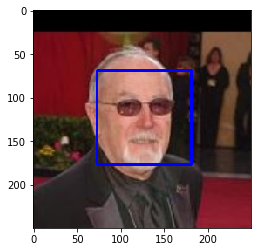

In [3]:
facecascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')
img = cv2.imread(human_paths[0])
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

faces = facecascade.detectMultiScale(gray)
print('Number of faces detected : {}'.format(str(len(faces))) )
for x,y,w,h in faces:
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)

color_img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

plt.imshow(color_img)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [4]:
def face_detector(paths):
    count = 0 
    img = cv2.imread(paths)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    faces = facecascade.detectMultiScale(gray)
    if len(faces) > 0:
        count += 1
    return count


human_subset = human_paths[:200]
dog_subset = dog_paths[:200]


Testing face_detector on a subset of data of human and dog.

###  Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_paths` have a detected human face?  
- What percentage of the first 100 images in `dog_paths` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_subset` and `dog_subset`.

I ran the code for 200 images of each dogs and human so my first algorithm got 198 humans detected and 29 dogs detected.
My second algorithm got 198 humans detected and 15 dogs detected.

In [6]:
dog_counter = 0
human_counter = 0
for i in range(0,200):
    count_for_human = face_detector(human_subset[i])
    count_for_dogs = face_detector(dog_subset[i])
    dog_counter += count_for_dogs
    human_counter += count_for_human
print('Detected Humans : {} \tDetected Dogs : {}'.format(str(human_counter),str(dog_counter)))

Detected Humans : 198 	Detected Dogs : 29


### Another face detecting algorithm

Used dlib for detecting faces which gave much more promising results compared to haarcascades.

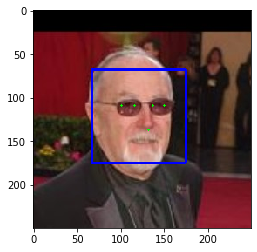

In [7]:
def rect_to_bb(rect):
	# take a bounding predicted by dlib and convert it
	# to the format (x, y, w, h) as we would normally do
	# with OpenCV
	x = rect.left()
	y = rect.top()
	w = rect.right() - x
	h = rect.bottom() - y
 
	# return a tuple of (x, y, w, h)
	return (x, y, w, h)

def shape_to_np(shape, dtype="int"):
	# initialize the list of (x, y)-coordinates
	coords = np.zeros((5, 2), dtype=dtype)
 
	# loop over the 68 facial landmarks and convert them
	# to a 2-tuple of (x, y)-coordinates
	for i in range(0, 5):
		coords[i] = (shape.part(i).x, shape.part(i).y)
 
	# return the list of (x, y)-coordinates
	return coords

def points_5(img_path,n):
    
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor('shape_predictor_5_face_landmarks.dat')
    count = 0
    #img = Image.open(img_path)
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    rect = detector(gray,1)
    shape = np.zeros((5,2),dtype = int)
    
    for r in rect:
        shape = predictor(gray,r)
        shape = shape_to_np(shape)
        count = 1
        if(n == 1):
            (x,y,w,h) = rect_to_bb(r)
            cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
            
            for x,y in shape:
                cv2.circle(img,(x,y),1,(0,255,0),-1)
    #plt.imshow(img)
    return count,img


(result,image) = points_5(human_paths[0],1)
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()

Tried the model on same dataset the results were as given below.

In [8]:
def face_detector_1(paths):
    count = 0
    result,image = points_5(paths,1)
    if result == 1:
        count += 1
    return count


Testing out the face_detector_1 on a subset of data of human and dog.

In [9]:
dog_counter = 0
human_counter = 0
for i in range(0,200):
    count_for_human = face_detector_1(human_subset[i])
    count_for_dogs = face_detector_1(dog_subset[i])
    dog_counter += count_for_dogs
    human_counter += count_for_human
print('Detected Humans : {} \tDetected Dogs : {}'.format(str(human_counter),str(dog_counter)))

Detected Humans : 198 	Detected Dogs : 15


face_detector_1 gives better results as the number of dogs detected as human are almost half of the face_detector results.

<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a [pre-trained model](http://pytorch.org/docs/master/torchvision/models.html) to detect dogs in images.  

### Obtain Pre-trained VGG-16 Model

The code cell below downloads the VGG-16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). 

In [13]:
import torch
import torchvision.models as models

VGG16 = models.vgg16(pretrained = True)

# print(if_cuda)
# if if_cuda:
#     VGG16 = VGG16.cuda()
print(VGG16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

### Making Predictions with a Pre-trained Model

In the next code cell, you will write a function that accepts a path to an image (such as `'dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'`) as input and returns the index corresponding to the ImageNet class that is predicted by the pre-trained VGG-16 model.  The output should always be an integer between 0 and 999, inclusive.

Before writing the function, make sure that you take the time to learn  how to appropriately pre-process tensors for pre-trained models in the [PyTorch documentation](http://pytorch.org/docs/stable/torchvision/models.html).

In [17]:
LABELS_URL = 'https://s3.amazonaws.com/outcome-blog/imagenet/labels.json'
# Let's get our class labels.
response = requests.get(LABELS_URL)  # Make an HTTP GET request and store the response.
labels = {int(key): value for key, value in response.json().items()}

def vgg16_predict(image_paths):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''
    #Loading the image through path
    img = Image.open(image_paths)
    #Necessary transforms required by the pretrained model
    transform_pipeline = transforms.Compose([transforms.Resize(224),
                                             transforms.ToTensor(),
                                             transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))])
    img = transform_pipeline(img)
    
    # PyTorch pretrained models expect the Tensor dims to be (num input imgs, num color channels, height, width).
    # Currently however, we have (num color channels, height, width); let's fix this by inserting a new axis.
    img  = img.unsqueeze(0) # Insert the new axis at index 0 i.e. in front of the other axes/dims. 
#     if if_cuda:
#         img = img.cuda()
#    Now that we have preprocessed our img, we need to convert it into a 
    # Variable; PyTorch models expect inputs to be Variables. A PyTorch Variable is a  
    # wrapper around a PyTorch Tensor.
    prediction  = VGG16(img)
    prediction = torch.max(prediction,1)[1].item()#prediction.data.numpy().argmax()
    return prediction #return predicted index

index = vgg16_predict(dog_paths[0])
print(index)

246


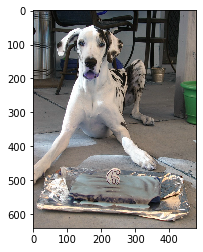

In [16]:
img  = cv2.imread(dog_paths[0])
plt.imshow(img)

In [18]:
def dog_detect(image_path):
    index = vgg16_predict(image_path)
    if index >= 151 and index <= 268:
        return True
    else:
        return False


### Obtain pre-trained VGG-19 Model


In [19]:
VGG19 = models.vgg19(pretrained = True)
# if if_cuda:
#     VGG19 = VGG19.cuda()
print(VGG19)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17): ReLU(inplace)

### Making Predictions with a Pre-trained Model

In the next code cell, you will write a function that accepts a path to an image (such as `'dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'`) as input and returns the index corresponding to the ImageNet class that is predicted by the pre-trained VGG-19 model.  The output should always be an integer between 0 and 999, inclusive.

Before writing the function, make sure that you take the time to learn  how to appropriately pre-process tensors for pre-trained models in the [PyTorch documentation](http://pytorch.org/docs/stable/torchvision/models.html).

In [20]:
 def VGG19_predict(image_path):
    '''
    Use pre-trained vgg-19 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to vgg-19 model's prediction
    '''
    img = Image.open(image_path).convert('RGB')
    #Necessary transforms required by the pretrained model
    transform_pipeline = transforms.Compose([transforms.Resize(224),
                                             transforms.ToTensor(),
                                             transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))])
    
    img  = transform_pipeline(img)
    
    # PyTorch pretrained models expect the Tensor dims to be (num input imgs, num color channels, height, width).
    # Currently however, we have (num color channels, height, width); let's fix this by inserting a new axis.
    img  = img.unsqueeze(0) # Insert the new axis at index 0 i.e. in front of the other axes/dims. 
    
    # Now that we have preprocessed our img, we need to convert it into a 
    # Variable; PyTorch models expect inputs to be Variables. A PyTorch Variable is a  
    # wrapper around a PyTorch Tensor.
#     if if_cuda:
#         img = img.cuda()
    #img  = Variable(img)
    prediction = VGG19(img)
    prediction = torch.max(prediction,1)[1].item()#prediction.data.numpy().argmax()
    return prediction

index = VGG19_predict(dog_paths[0])
print(index)

246


In [21]:
def dog_detect_1(image_path):
    count = 0
    index = VGG19_predict(image_path)
    if index >=151 and index <= 268:
        return True
    else:
        return False
    

## Results obtain on subset using pretrained model VGG16 and VGG19

In [22]:
count_1 = 0
count_2 = 0
for i in range(len(human_subset)):
    if dog_detect(human_subset[i]) == True:
        count_1 += 1
for i in range(len(dog_subset)):
    if dog_detect(dog_subset[i]) == True:
        count_2 += 1
print('Model : {} \tHuman Detected : {} \tDogs Detected : {}'.format('VGG16',str(count_1),str(count_2)))
count_1 = 0
count_2 = 0
for i in range(len(human_subset)):
    if dog_detect_1(human_subset[i]) == True:
        count_1 += 1
for i in range(len(dog_subset)):
    if dog_detect_1(dog_subset[i]) == True:
        count_2 += 1
print('Model : {} \tHuman Detected : {} \tDogs Detected : {}'.format('VGG19',str(count_1),str(count_2)))


Model : VGG16 	Human Detected : 0 	Dogs Detected : 195
Model : VGG19 	Human Detected : 2 	Dogs Detected : 195


### Assess the Dog Detector

__Question 2:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_paths` have a detected dog?  
- What percentage of the images in `dog_paths` have a detected dog?

I tried two pretrained model and observed that both of them are giving almost similar results. So for detection we can use any one of them.

Model : VGG16 	Human Detected : 0 	Dogs Detected : 195

Model : VGG19 	Human Detected : 2 	Dogs Detected : 195

VGG16 giving better results as compared to VGG19

---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 10%.  In Step 4 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have trouble distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively).  You may find [this documentation on custom datasets](http://pytorch.org/docs/stable/torchvision/datasets.html) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [30]:
batch_size = 20
num_worker = 0
transform_train = transforms.Compose([transforms.RandomResizedCrop(224),
                                      transforms.RandomRotation(20),
                                      transforms.RandomHorizontalFlip(0.2),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))])
transform_val = transforms.Compose([transforms.Resize(256),
                                    transforms.CenterCrop(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))])
transform_test = transforms.Compose([transforms.Resize((224,224)),
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))])

traindata = datasets.ImageFolder('dogImages/train',transform = transform_train)
valdata = datasets.ImageFolder('dogImages/valid',transform = transform_val)
testdata = datasets.ImageFolder('dogImages/test',transform = transform_test)

train_loader = torch.utils.data.DataLoader(traindata, batch_size = batch_size, shuffle = True, num_workers = num_worker)
val_loader = torch.utils.data.DataLoader(valdata, batch_size = batch_size, shuffle = False, num_workers = num_worker)
test_loader = torch.utils.data.DataLoader(testdata, batch_size = batch_size, shuffle = False, num_workers = num_worker)
classes = traindata.classes

**Question 3:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?


**Answer**:
I resized all my images to (224 ,224) dimension as it was the least dimension required for the pretrained model basic requirement. If I have chosen another dimension it would be bigger than this which will take more computation time to process, thats why I chose (224,224). For this process I used   transforms.Resize(),transforms.RandomResizedCrop() and transforms.CenterCrop().

Yes I augmented the training data with random (224,224) cropping, random rotation of 20 degrees and allowing horizontal flip with a probability of 20%.

### Model Architecture

Create a CNN to classify dog breed.  Use the template in the code cell below.

In [26]:
class Network(nn.Module):
    def __init__(self):
        super(Network,self).__init__()
        #self.conv1 = nn.Conv2d(3,16,3,padding = 1)
        self.conv1 = nn.Conv2d(3,32,3,stride = 2,padding = 1)
        self.conv2 = nn.Conv2d(32,64,3,stride = 2,padding = 1)
        self.conv3 = nn.Conv2d(64,128,3,padding = 1)
        
        self.pool = nn.MaxPool2d(2,2)
        
        self.fc1 = nn.Linear(7*7*128,500)
        #self.fc2 = nn.Linear(500,500)
        self.fc2 = nn.Linear(500,133)
        self.drop = nn.Dropout(p = 0.3)
    
    def forward(self,x):
        #x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1,7*7*128)
        x = self.drop(x)
        x = self.drop(F.relu(self.fc1(x)))
        x = self.fc2(x)
        
        return x
    
model = Network()
print(model)
if if_cuda:
    model.cuda()

Network(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=6272, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=133, bias=True)
  (drop): Dropout(p=0.3)
)


__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__  I applied 3 convolution layer, first 2 with stride = 2 and kernel size = 3 to reduce the width and height dimension and the last convolution layer I chose stride to be 1 and kernel size  = 3. By the end of all the convolution layers and max pooling, the resultant vector was of shape (6272) which was fed to the fully connected layer. 

fc1 takes the input vector(6272 with dropouts of probability 30%) and generate a hidden layer with 500 neurons, on which relu activation function is applied along with dropout to avoid overfitting. 

fc2 takes the 500 neurons as input and gives the score for the dog class breeds.  

###  Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_1.pt'`.

In [28]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),lr= 0.05)

epochs = 30
val_loss_min = np.Inf
for e in range(epochs):
    training_loss = 0.0
    val_loss = 0.0
    model.train()
    for images,labels in train_loader:
        
        if if_cuda:
            images,labels = images.cuda(),labels.cuda()
            
        optimizer.zero_grad()
        output = model.forward(images)
        loss = criterion(output,labels)
        loss.backward()
        optimizer.step()
        
        training_loss += loss.item()*images.size(0)
    #torch.cuda.empty_cache() 
    model.eval()
    for images,labels in val_loader:
        
        if if_cuda: 
            images,labels = images.cuda(),labels.cuda()
        output = model.forward(images)
        loss = criterion(output,labels)
        val_loss += loss.item()*images.size(0)
    #torch.cuda.empty_cache() 
    training_loss = training_loss/len(train_loader.dataset)
    val_loss = val_loss/len(val_loader.dataset)
    print('Epoch : {} \tTraining Loss : {: .4f} \tValidation Loss : {: .4f}'.format(e+1,training_loss,val_loss))
    
    if val_loss <= val_loss_min:
        print('Validation Loss decreased ({: .4f} ---> {: .4f}. Saving Model)'.format(val_loss_min,val_loss))
        torch.save(model.state_dict(),'saved_models/model_1.pt')
        val_loss_min = val_loss

Epoch : 1 	Training Loss :  4.8709 	Validation Loss :  4.8203
Validation Loss decreased ( inf --->  4.8203. Saving Model)
Epoch : 2 	Training Loss :  4.7415 	Validation Loss :  4.5790
Validation Loss decreased ( 4.8203 --->  4.5790. Saving Model)
Epoch : 3 	Training Loss :  4.6207 	Validation Loss :  4.4685
Validation Loss decreased ( 4.5790 --->  4.4685. Saving Model)
Epoch : 4 	Training Loss :  4.5580 	Validation Loss :  4.3702
Validation Loss decreased ( 4.4685 --->  4.3702. Saving Model)
Epoch : 5 	Training Loss :  4.4922 	Validation Loss :  4.2996
Validation Loss decreased ( 4.3702 --->  4.2996. Saving Model)
Epoch : 6 	Training Loss :  4.4402 	Validation Loss :  4.2376
Validation Loss decreased ( 4.2996 --->  4.2376. Saving Model)
Epoch : 7 	Training Loss :  4.3988 	Validation Loss :  4.2815
Epoch : 8 	Training Loss :  4.3287 	Validation Loss :  4.1244
Validation Loss decreased ( 4.2376 --->  4.1244. Saving Model)
Epoch : 9 	Training Loss :  4.2775 	Validation Loss :  4.1044
Vali

If you have trained the model once, you can directly load the weights and other parameters after creating a network using this.

In [4]:
model.load_state_dict(torch.load('saved_models/model_1.pt'))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

### Test the Model

Try out your model on the test dataset of dog images.  Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 10%.

In [31]:
test_loss = 0.0
class_correct = list(0. for i in range(133))
class_total = list(0. for i in range(133))
model.eval()
for images,labels in test_loader:
     
    if if_cuda:
        images,labels = images.cuda(),labels.cuda()
    output = model.forward(images)
    loss = criterion(output,labels)
    test_loss += loss.item()*images.size(0)
    pred = torch.max(output, 1)[1]
    correct_tensor = pred.eq(labels.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not if_cuda else np.squeeze(correct_tensor.cpu().numpy())
    
    for i in range(len(labels.data)):
        target = labels.data[i]
        class_correct[target] += correct[i].item()
        class_total[target] += 1
        
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.4f}\n'.format(test_loss))
for i in range(133):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 3.7077

Test Accuracy of 001.Affenpinscher: 12% ( 1/ 8)
Test Accuracy of 002.Afghan_hound:  0% ( 0/ 8)
Test Accuracy of 003.Airedale_terrier:  0% ( 0/ 6)
Test Accuracy of 004.Akita:  0% ( 0/ 8)
Test Accuracy of 005.Alaskan_malamute: 20% ( 2/10)
Test Accuracy of 006.American_eskimo_dog: 37% ( 3/ 8)
Test Accuracy of 007.American_foxhound: 57% ( 4/ 7)
Test Accuracy of 008.American_staffordshire_terrier: 12% ( 1/ 8)
Test Accuracy of 009.American_water_spaniel: 25% ( 1/ 4)
Test Accuracy of 010.Anatolian_shepherd_dog:  0% ( 0/ 6)
Test Accuracy of 011.Australian_cattle_dog: 11% ( 1/ 9)
Test Accuracy of 012.Australian_shepherd: 22% ( 2/ 9)
Test Accuracy of 013.Australian_terrier:  0% ( 0/ 6)
Test Accuracy of 014.Basenji: 22% ( 2/ 9)
Test Accuracy of 015.Basset_hound: 10% ( 1/10)
Test Accuracy of 016.Beagle:  0% ( 0/ 8)
Test Accuracy of 017.Bearded_collie: 37% ( 3/ 8)
Test Accuracy of 018.Beauceron: 42% ( 3/ 7)
Test Accuracy of 019.Bedlington_terrier:  0% ( 0/ 6)
Test Accuracy of 020

If we train this model on more number of epochs, its accuracy will increase however the increase is very slow.
This is because of the lack of training data and the CNN architecture. So to get good accuracy we will use transfer learning. 

---
<a id='step4'></a>
## Step 4: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.Here we will be using resnet50 pretrained model.


In [32]:
res50 = models.resnet50(pretrained=True)

In [33]:
for param in res50.parameters():
    param.requires_grad = False


In [34]:
res50.fc = nn.Linear(2048,133,bias =True)

In [35]:
fc_params = res50.fc.parameters()
for param in fc_params:
    param.requires_grad = True

In [36]:
res50

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [37]:
if if_cuda:
    res50 = res50.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(res50.fc.parameters(),lr= 0.001)


__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

I picked ResNet as a transfer model because it performed outstanding on Image Classification. I looked into the structure and functions of ResNet. The core idea of ResNet is introducing a so-called “identity shortcut connection” that skips one or more layers. I guess this prevents overfitting when it's training. Just changed the last fully connected layer with output 133 (dogs classes)

### Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [38]:
epochs = 65
val_loss_min = np.Inf
for e in range(epochs):
    training_loss = 0.0
    val_loss = 0.0
    res50.train()
    for images,labels in train_loader:
        if if_cuda:
            images,labels = images.cuda(),labels.cuda()
        optimizer.zero_grad()
        output = res50(images)
        loss = criterion(output,labels)
        loss.backward()
        optimizer.step()
        training_loss += loss.item()*images.size(0)
    
    res50.eval()    
    for images,labels in val_loader:
        if if_cuda:
            images,labels = images.cuda(),labels.cuda()
        output = res50(images)
        loss = criterion(output,labels)
        val_loss += loss.item()*images.size(0)
        
    training_loss = training_loss/len(train_loader.dataset)
    val_loss = val_loss/len(val_loader.dataset)
    print('Epoch : {} \tTraining Loss : {: .4f} \tValidation Loss : {: .4f}'.format(e+1,training_loss,val_loss))
    
    if val_loss <= val_loss_min:
        print('Validation Loss decreased ({: .4f} ---> {: .4f}. Saving Model)'.format(val_loss_min,val_loss))
        torch.save(res50.state_dict(),'saved_models/model_transfer.pt')
        val_loss_min = val_loss

Epoch : 1 	Training Loss :  4.8455 	Validation Loss :  4.7001
Validation Loss decreased ( inf --->  4.7001. Saving Model)
Epoch : 2 	Training Loss :  4.6647 	Validation Loss :  4.4852
Validation Loss decreased ( 4.7001 --->  4.4852. Saving Model)
Epoch : 3 	Training Loss :  4.5045 	Validation Loss :  4.2850
Validation Loss decreased ( 4.4852 --->  4.2850. Saving Model)
Epoch : 4 	Training Loss :  4.3556 	Validation Loss :  4.0757
Validation Loss decreased ( 4.2850 --->  4.0757. Saving Model)
Epoch : 5 	Training Loss :  4.2092 	Validation Loss :  3.8880
Validation Loss decreased ( 4.0757 --->  3.8880. Saving Model)
Epoch : 6 	Training Loss :  4.0695 	Validation Loss :  3.7243
Validation Loss decreased ( 3.8880 --->  3.7243. Saving Model)
Epoch : 7 	Training Loss :  3.9406 	Validation Loss :  3.5432
Validation Loss decreased ( 3.7243 --->  3.5432. Saving Model)
Epoch : 8 	Training Loss :  3.7934 	Validation Loss :  3.3530
Validation Loss decreased ( 3.5432 --->  3.3530. Saving Model)
Epo

In [ ]:
res50.load_state_dict(torch.load('saved_models/model_transfer.pt'))

### Testing

In [39]:
test_loss = 0.0
class_correct = list(0. for i in range(133))
class_total = list(0. for i in range(133))
res50.eval()
for images,labels in test_loader:
     
    if if_cuda:
        images,labels = images.cuda(),labels.cuda()
    output = res50(images)
    loss = criterion(output,labels)
    test_loss += loss.item()*images.size(0)
    pred = torch.max(output, 1)[1]
    correct_tensor = pred.eq(labels.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not if_cuda else np.squeeze(correct_tensor.cpu().numpy())
    
    for i in range(len(labels.data)):
        target = labels.data[i]
        class_correct[target] += correct[i].item()
        class_total[target] += 1
        
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.4f}\n'.format(test_loss))
for i in range(133):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.9379

Test Accuracy of 001.Affenpinscher: 75% ( 6/ 8)
Test Accuracy of 002.Afghan_hound: 100% ( 8/ 8)
Test Accuracy of 003.Airedale_terrier: 83% ( 5/ 6)
Test Accuracy of 004.Akita: 62% ( 5/ 8)
Test Accuracy of 005.Alaskan_malamute: 100% (10/10)
Test Accuracy of 006.American_eskimo_dog: 100% ( 8/ 8)
Test Accuracy of 007.American_foxhound: 85% ( 6/ 7)
Test Accuracy of 008.American_staffordshire_terrier: 87% ( 7/ 8)
Test Accuracy of 009.American_water_spaniel: 50% ( 2/ 4)
Test Accuracy of 010.Anatolian_shepherd_dog: 66% ( 4/ 6)
Test Accuracy of 011.Australian_cattle_dog: 66% ( 6/ 9)
Test Accuracy of 012.Australian_shepherd: 100% ( 9/ 9)
Test Accuracy of 013.Australian_terrier: 66% ( 4/ 6)
Test Accuracy of 014.Basenji: 100% ( 9/ 9)
Test Accuracy of 015.Basset_hound: 100% (10/10)
Test Accuracy of 016.Beagle: 100% ( 8/ 8)
Test Accuracy of 017.Bearded_collie: 100% ( 8/ 8)
Test Accuracy of 018.Beauceron: 100% ( 7/ 7)
Test Accuracy of 019.Bedlington_terrier: 100% ( 6/ 6)
Test Accur

In [40]:
# list of class names by index, i.e. a name can be accessed like class_names[0]
class_names = [item[4:].replace("_", " ") for item in train_loader.dataset.classes]

In [41]:
class_names[:10]

['Affenpinscher',
 'Afghan hound',
 'Airedale terrier',
 'Akita',
 'Alaskan malamute',
 'American eskimo dog',
 'American foxhound',
 'American staffordshire terrier',
 'American water spaniel',
 'Anatolian shepherd dog']

In [42]:
from PIL import Image
import torchvision.transforms as transforms

def get_image(image_paths):
    img = Image.open(image_paths).convert('RGB')
    required_transforms = transforms.Compose([transforms.Resize((224,224)),
                                             transforms.ToTensor(),
                                             transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))])
    img = required_transforms(img)[:3,:,:].unsqueeze(0)
    return img

In [43]:
def dog_breed_classifier(model,class_name,img_path):
    img = get_image(img_path)
    model = model.cpu()
    model.eval()
    index = torch.argmax(model(img))
    return class_name[index]

In [44]:
for path in range(len(app_paths)):
    prediction = dog_breed_classifier(res50, class_names, app_paths[path])
    print("image_file_name: {}, \t predition breed: {}".format(app_paths[path], prediction))

image_file_name: images/American_water_spaniel_00648.jpg, 	 predition breed: Boykin spaniel
image_file_name: images/sample_dog_output.png, 	 predition breed: Entlebucher mountain dog
image_file_name: images/Labrador_retriever_06455.jpg, 	 predition breed: Chesapeake bay retriever
image_file_name: images/Welsh_springer_spaniel_08203.jpg, 	 predition breed: Welsh springer spaniel
image_file_name: images/Labrador_retriever_06457.jpg, 	 predition breed: Labrador retriever
image_file_name: images/Labrador_retriever_06449.jpg, 	 predition breed: Labrador retriever
image_file_name: images/Brittany_02625.jpg, 	 predition breed: Brittany
image_file_name: images/sample_human_output.png, 	 predition breed: Dogue de bordeaux
image_file_name: images/Curly_coated_retriever_03896.jpg, 	 predition breed: Curly-coated retriever
image_file_name: images/sample_cnn.png, 	 predition breed: American eskimo dog


---
<a id='step5'></a>
## Step 5: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `dog_detector` functions developed above.  You are __required__ to use your CNN from Step 4 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)



In [45]:
from PIL import Image

def run_app(model,class_names,img_path):
    img = Image.open(img_path)
    plt.imshow(img)
    plt.show()
    if dog_detect_1(img_path) is True:
        prediction = dog_breed_classifier(model,class_names,img_path)
        print('Hello, Dog!!')
        print('You look like a ---> {}'.format(str(prediction)))
        return
    else:
        if face_detector_1(img_path) > 0:
            prediction = dog_breed_classifier(model,class_names,img_path)
            print('Hello, human!!')    
            print('You look like a ---> {}'.format(str(prediction)))
            return

        else:
            print('Neither the dog nor human was detected !! Error...')
            return
        

10


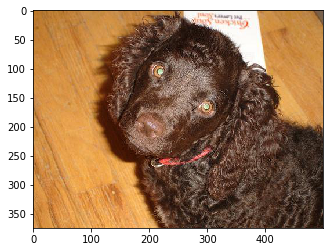

Hello, Dog!!
You look like a ---> Boykin spaniel


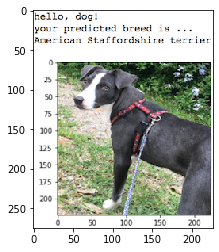

Hello, Dog!!
You look like a ---> Entlebucher mountain dog


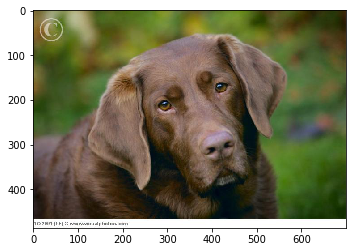

Hello, Dog!!
You look like a ---> Chesapeake bay retriever


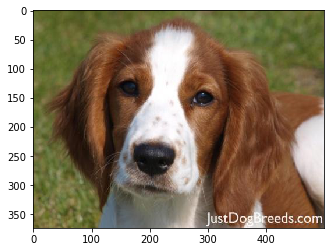

Hello, Dog!!
You look like a ---> Welsh springer spaniel


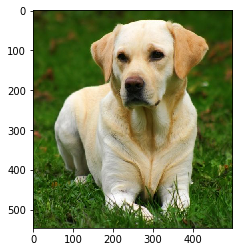

Hello, Dog!!
You look like a ---> Labrador retriever


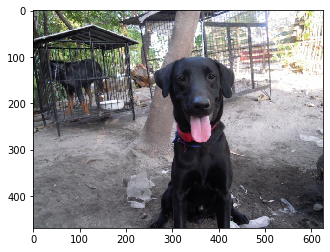

Hello, Dog!!
You look like a ---> Labrador retriever


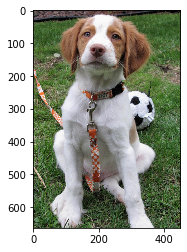

Hello, Dog!!
You look like a ---> Brittany


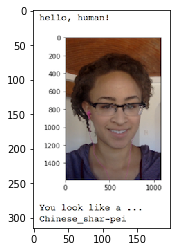

Hello, human!!
You look like a ---> Dogue de bordeaux


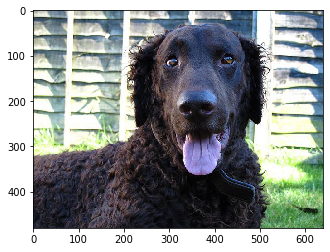

Hello, Dog!!
You look like a ---> Curly-coated retriever


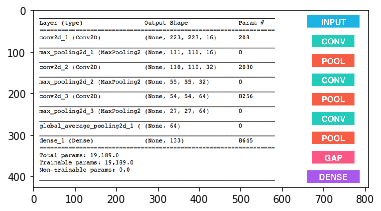

Neither the dog nor human was detected !! Error...


In [46]:
print(len(app_paths))
for path in range(len(app_paths)):
    run_app(res50,class_names,app_paths[path])
#run_app(res50,class_names,app_paths[6])

---
<a id='step6'></a>
## Step 6: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that _you_ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

-> Adding more training data and trainig on more number of epochs will improve the model accuracy.

-> Doing a bit more data augmentation(like flipping vertically etc) will help the model to generalize the results.

-> Testing other pretrained models and hypertuning parameters may help to improve the performance of the algorithm.

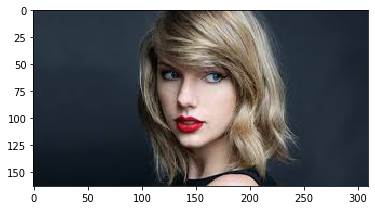

Hello, human!!
You look like a ---> Maltese


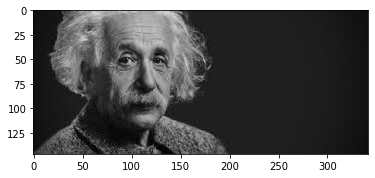

Hello, Dog!!
You look like a ---> Irish water spaniel


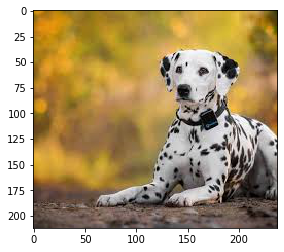

Hello, Dog!!
You look like a ---> Dalmatian


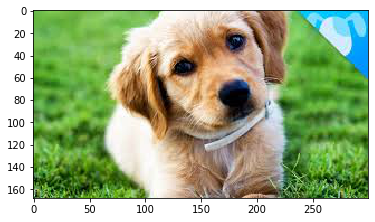

Hello, Dog!!
You look like a ---> Golden retriever


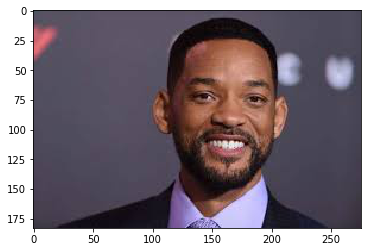

Hello, human!!
You look like a ---> Basenji


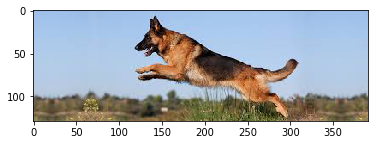

Hello, Dog!!
You look like a ---> German shepherd dog


In [47]:
test_paths = np.array(glob('test_images/*'))
for path in range(len(test_paths)):
    run_app(res50,class_names,test_paths[path])